# Notebook to match VASCA sources to SIMBAD database sources positionally
Set your option in the cell bellow

In [1]:
from astropy import units as uu
region_name = "MDIS_10-800" # "TDS" # _ELAISN1
simbad_query = False
radius = 5 * uu.arcsec

In [2]:
%matplotlib widget
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from regions import CircleSkyRegion
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import pixel_to_skycoord
from astropy.table import unique, Table
import numpy as np
from vasca.region import Region
from vasca.field import BaseField
import vasca.visualization as vvis
from vasca.tables import TableCollection, dd_vasca_columns
from vasca.utils import otype2ogroup,dd_ogrp2otypes, dd_ogrp2col
from astroquery.simbad import Simbad
from itertools import cycle
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=["0.8","b",'r', 'g', 'k', 'y',"m","c"])


#prepare file names
region_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+".fits"
simbad_fname = "./vasca_pipeline/"+region_name+"/simbad_"+region_name+".fits"

# Get region and source coordinates
rg = Region()
rg.load_from_fits(region_fname)
sel_src = rg.tt_sources["sel"]
tt_src = rg.tt_sources[sel_src]
display(tt_src[0:2])
#Simbad.get_field_description('otype')

fd_src_id,nr_det,ra,dec,pos_err,pos_xv,pos_var,pos_cpval,pos_rchiq,assoc_id,assoc_dist,obs_filter_id,sel,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,assoc_ffactor,assoc_fdiff_s2n,rg_fd_id,rg_src_id,nr_fd_srcs,hr,hr_err
,,deg,deg,arcsec,arcsec2,arcsec2,,,,arcsec,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,,,,,,
int32,int32[2],float64,float64,float32,float32,float32,float32,float32,int64,float32,int32[2],bool,float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],int64,int32,int32,float32,float32
-1,175 .. 98,150.1949174665478,2.067917488917891,0.041145824,-0.33278635,0.15272313,1.0,0.30049813,1149,0.063385345,1 .. 2,True,13.825647 .. 8.437315,0.08337321 .. 0.10609022,0.009582018 .. 0.011795453,3.6751015 .. 2.2731214,1.1984851e-35 .. 1.03325244e-10,2.96802 .. 2.1985245,0.9611866 .. 1.0157672,-4.8286705 .. 0.9930416,-1,25,10,0.60487556,0.009556857
-1,147 .. 130,150.179954836128,2.1103311508629656,0.041988235,-0.28247258,0.24774879,1.0,0.47760198,90,0.04686192,1 .. 2,True,17.842085 .. 6.3060455,0.109606236 .. 0.08087121,0.0074414667 .. 0.005808099,4.9870253 .. 1.288465,1.2902245e-17 .. 0.15441209,2.334232 .. 1.1265781,0.9595368 .. 0.9832187,-5.593553 .. -1.0534607,-1,30,10,0.34160548,0.006894858


### Query the data or read from file

In [3]:
# Get matches
mt = TableCollection()
if simbad_query:
    # Run query
    src_coord = SkyCoord(tt_src["ra"].quantity,tt_src["dec"].quantity,frame='icrs')
    customSimbad = Simbad()
    customSimbad.TIMEOUT = 180
    customSimbad.add_votable_fields('otype',"otype(opt)","otypes")
    tt_simbad = customSimbad.query_region(src_coord,radius=radius)
    
    # Change type to be handabel by astropy
    tt_simbad["MAIN_ID"] = tt_simbad["MAIN_ID"].data.astype("S32")
    tt_simbad["COO_BIBCODE"] = tt_simbad["COO_BIBCODE"].data.astype("S32")
    tt_simbad["OTYPE"] = tt_simbad["OTYPE"].data.astype("S32")
    tt_simbad["OTYPE_opt"] = tt_simbad["OTYPE_opt"].data.astype("S32")
    tt_simbad["OTYPES"] = tt_simbad["OTYPES"].data.astype("S32")

    # Write simbad and source info into matching tables
    src_idx = tt_simbad["SCRIPT_NUMBER_ID"]-1
    tt_simbad["rg_src_id"] = tt_src[src_idx]["rg_src_id"]
    tt_simbad["match_id"] = np.array(range(0,len(tt_simbad)), dtype= np.int32)

    #Create association table
    tt_match = Table(tt_src["rg_src_id","ra","dec","pos_err","obs_filter_id","sel","flux","flux_err","flux_nxv","hr","hr_err","nr_det"])
    tt_match.meta["rad"]=str(radius)

    # Add tables to table collection and write
    mt.add_table(tt_match,"tt_match")
    mt.add_table(tt_simbad,"tt_simbad")

    #Get SIMBAD table with the closest match
    tu_simbad = unique(tt_simbad, keys='SCRIPT_NUMBER_ID')
    display(tt_simbad[:2])

    #Add columns to be filled
    otype = np.array([dd_vasca_columns["otype"]["default"]]*len(tt_match), dtype=dd_vasca_columns["otype"]["dtype"])
    mt.add_column("tt_match","otype",otype)
    otype = np.array([dd_vasca_columns["match_id"]["default"]]*len(tt_match), dtype=dd_vasca_columns["match_id"]["dtype"])
    mt.add_column("tt_match","match_id",otype)

    #Copy information into mt.tt_match table
    mt.tt_match.add_index("rg_src_id")
    mt_idx = mt.tt_match.loc_indices["rg_src_id", tu_simbad["rg_src_id"]]
    mt.tt_match["otype"][mt_idx] = tu_simbad["OTYPE_opt"]
    mt.tt_match["match_id"][mt_idx] = tu_simbad["match_id"]
 
    #Write collectiion
    mt.write_to_fits(simbad_fname)
else:
    #Load collection
    mt.load_from_fits(simbad_fname)    
    
# Add object group ID
def add_ogrp(tc,tt_name):
    "Helper funtion to add ogrp:id column to tables"
    tt = tc.__dict__[tt_name]
    tc.add_column(tt_name,"ogrp")
    for ii in range(len(tt)):
        tt["ogrp"][ii] = otype2ogroup(tt["otype"][ii])
add_ogrp(mt,"tt_match")
display(mt.tt_match[:2])  

rg_src_id,ra,dec,pos_err,obs_filter_id,sel,flux,flux_err,flux_nxv,hr,hr_err,nr_det,otype,match_id,ogrp
,deg,deg,arcsec,,,1e-06 Jy,1e-06 Jy,,,,,,,
int32,float64,float64,float32,int32[2],bool,float32[2],float32[2],float32[2],float32,float32,int32[2],bytes32,int32,bytes8
25,150.1949174665478,2.067917488917891,0.041145824,1 .. 2,True,13.825647 .. 8.437315,0.08337321 .. 0.10609022,0.009582018 .. 0.011795453,0.60487556,0.009556857,175 .. 98,Sy1,0,AGN
30,150.179954836128,2.1103311508629656,0.041988235,1 .. 2,True,17.842085 .. 6.3060455,0.109606236 .. 0.08087121,0.0074414667 .. 0.005808099,0.34160548,0.006894858,147 .. 130,GrG,1,GAL


### Plot found object types

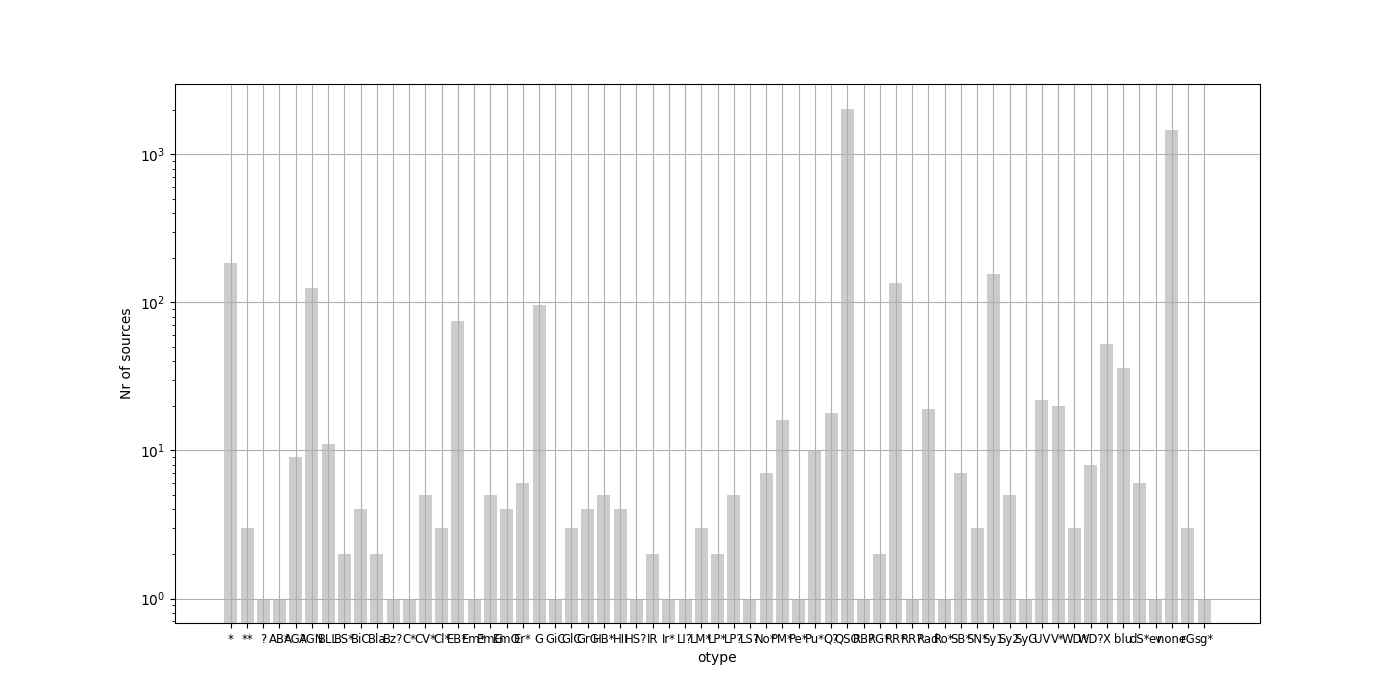

otype     Label      Candidate               Description                                 Category                                          Subcategory                          ogrp
                                                                                                                                                                                    
----- -------------- --------- --------------------------------------- ------------------------------------------- ------------------------------------------------------------ ----
    ?        Unknown        --                Object of Unknown Nature 8. BLENDS, ERRORS, NOT WELL DEFINED OBJECTS                                                           --  UNK
    *           Star        --                                    Star                        1. TAXONOMY OF STARS                                                           --    *
   **             **       **?                 Double or Multiple Star                        1

In [4]:
otypes, otype_cts= np.unique(mt.tt_match["otype"],return_counts=True)
fig_otypes = plt.figure("Source types",figsize=(14, 7))
plt.bar( range(len(otypes)), otype_cts, align='center')
plt.xticks(range(len(otypes)), otypes, size='small')
plt.yscale('log')
plt.grid()
plt.xlabel("otype")
plt.ylabel("Nr of sources")
plt.show()

tt_nodes = Table.read('./resources/SIMBAD_otypes/otypes_nodes.csv') #, format='ascii.daophot'
ids, ids_idx, _ = np.intersect1d(tt_nodes["Id"],otypes,return_indices=True)
candidate = np.asarray(np.ma.masked_array(data = tt_nodes["Candidate"],mask = False, fill_value = "none"))
can, can_idx, _ = np.intersect1d(candidate,otypes,return_indices=True)
all_idx = np.unique(np.append(ids_idx,can_idx))
tt_nodes.rename_column('Id', 'otype')
mt.add_table(tt_nodes[all_idx],"tt_otypes")
add_ogrp(mt,"tt_otypes")
mt.tt_otypes["otype","Label","Candidate","Description","Category","Subcategory","ogrp"].pprint_all()#show_dtype=True #,"Status","Priority"

### Scatter plots of source variables by group

dict_keys(['UNK', 'AGN', 'GAL', '*', 'WD', 'PM*', 'CVN', 'B*', 'Grv', 'SN', 'S*', 'Env'])


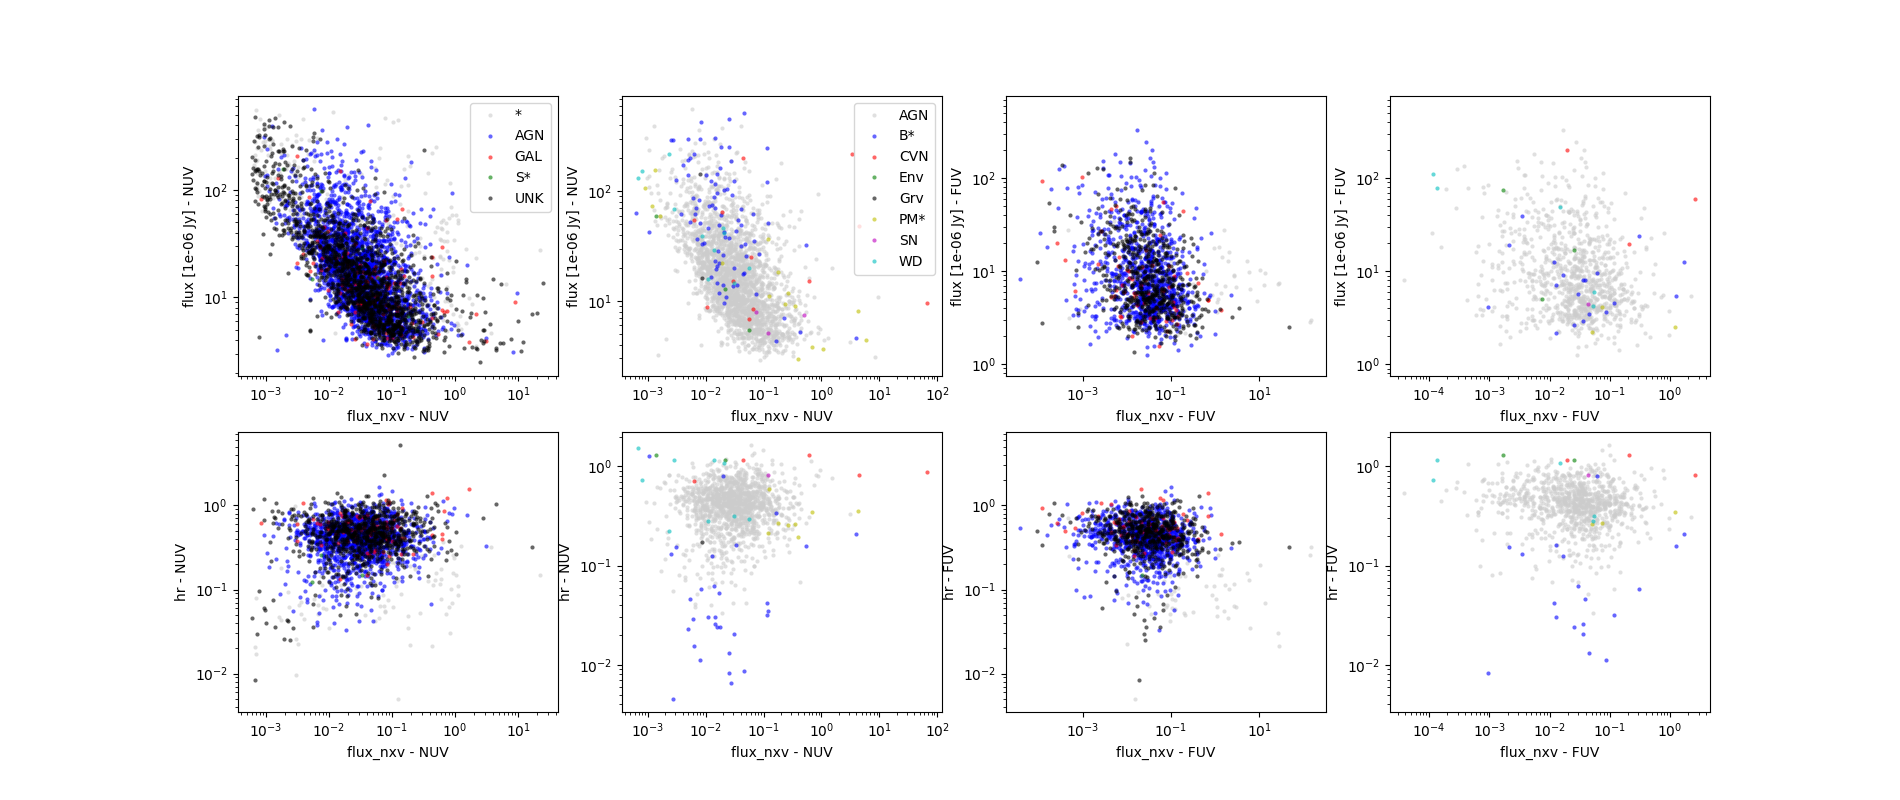

In [5]:
plot_kwargs = {"markersize": 3.0,"alpha":0.6}
fig, axs = plt.subplots(2, 4, figsize=(19, 8))
axs = axs.flatten()
plt_ogrops = [["AGN","GAL","UNK",'*',"S*"],["AGN",'WD', 'PM*', 'CVN', 'B*', 'Grv', 'SN',"Env"]]

plt_flts = [1,2]
ctr = 0
for flt in plt_flts:
    for ogrps in plt_ogrops:
        vvis.plot_table_scatter(mt.tt_match,"flux_nxv", "flux", ax=axs[ctr], xscale="log",yscale="log", obs_filter_id=flt, grp_var="ogrp",grp_vals = ogrps,**plot_kwargs)
        vvis.plot_table_scatter(mt.tt_match,"flux_nxv", "hr", ax=axs[ctr+4], xscale="log",yscale="log", obs_filter_id=flt, grp_var="ogrp",grp_vals = ogrps,**plot_kwargs)
        ctr +=1
_ = axs[0].legend()
_ = axs[1].legend()
print(dd_ogrp2otypes.keys())

### Print info for selected sources

In [10]:
# Make selection
sel_otype = mt.tt_match["otype"] ==  "No*"#"HS?" #"BS*" #"PM*" # # "SN*" #"EB*"
sel_otypes = (mt.tt_match["otype"] ==  "LS?")  + (mt.tt_match["otype"] =="LI?")
sel_flux_nxv = mt.tt_match["flux_nxv"][:,0]>2
sel_flux_hr = mt.tt_match["hr"]>2
sel_srcs =  sel_flux_nxv #sel_otype # sel_flux_nxv_fuv # sel_flux_hr#

#Display match and simbad table for selected sources
display(mt.tt_match[sel_srcs])
mt.tt_simbad.add_index("match_id")

# Show SIMBAD info if mtach was found
sel_match_id_srcs = (mt.tt_match["match_id"]>0)*sel_srcs
if sel_match_id_srcs.sum() >0:
    tt_simbad_sel =  mt.tt_simbad.loc[mt.tt_match["match_id"][sel_match_id_srcs]]
    display(tt_simbad_sel)

#Print oout list of source IDs to be used for further use, e.g. in inspect_sources.ipynb
print("srcs_ids = [", end="")
for src_id in mt.tt_match[sel_srcs]["rg_src_id"].data:
    print(src_id,",", end="")
print("]")

rg_src_id,ra,dec,pos_err,obs_filter_id,sel,flux,flux_err,flux_nxv,hr,hr_err,nr_det,otype,match_id,ogrp
,deg,deg,arcsec,,,1e-06 Jy,1e-06 Jy,,,,,,,
int32,float64,float64,float32,int32[2],bool,float32[2],float32[2],float32[2],float32,float32,int32[2],bytes32,int32,bytes8
3900,150.22831884456286,2.269886740591147,0.29041144,1 .. 0,True,3.092427 .. -1.0,0.2235056 .. -1.0,8.368637 .. -100.0,-1.0,-1.0,10 .. -1,AGN,228,AGN
12909,53.51697239173307,-27.941627946211444,0.07158798,1 .. 2,True,4.205877 .. 4.409619,0.081059024 .. 0.11404071,3.0603263 .. 0.048226316,0.3295063,0.019855477,67 .. 45,QSO,488,AGN
12980,53.44915920680709,-27.499030477624498,0.090595126,1 .. 2,True,3.7669249 .. 2.5113854,0.079283096 .. 0.58577585,2.7439303 .. -100.0,-1.0,-1.0,75 .. 1,none,-1,UNK
23259,242.68796139057343,56.16066860222422,0.18438716,1 .. 2,True,3.2209144 .. 2.8791478,0.16158082 .. 0.670552,4.5173016 .. -100.0,1.0483983,0.336938,18 .. 1,none,-1,UNK
23703,242.233580139594,56.42015253267921,0.1340013,1 .. 2,True,9.907438 .. 25.090893,0.20202076 .. 0.81195325,2.7687387 .. 0.00318659,0.71864426,0.04638169,20 .. 4,none,-1,UNK
28623,160.85459439209984,56.54944760481319,0.0864584,1 .. 2,True,48.12061 .. 59.228115,0.23283403 .. 0.7288154,4.5429554 .. 2.6537988,0.8122526,0.01138824,30 .. 10,CV*,800,CVN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506417,33.142874555607314,-5.29260478713723,0.34207028,1 .. 0,True,6.9566526 .. -1.0,0.4117867 .. -1.0,2.10664 .. -100.0,-1.0,-1.0,5 .. -1,G,3428,GAL


MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,OTYPE,OTYPE_opt,OTYPES,SCRIPT_NUMBER_ID,rg_src_id,match_id
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,,,,,,
bytes32,bytes13,bytes13,int16,int16,float32,float32,int16,bytes1,bytes1,bytes32,bytes32,bytes32,bytes32,int32,int32,int32
ACS-GC 20089821,10 00 54.751,+02 16 11.27,7,7,--,--,0,C,O,2020ApJ...888...78S,AGN,AGN,EmG|rG|BiC|AGN|NIR|AGN|rG|G|G|G|,155,3900,228
DES J033404.11-275630.0,03 34 04.099,-27 56 29.90,7,7,--,--,0,C,O,2017AJ....153..107T,QSO,QSO,AGN|QSO|G,415,12909,488
SDSS J104325.06+563258.1,10 43 25.0792,+56 32 57.991,14,14,0.290,0.333,90,A,O,2020yCat.1350....0G,CataclyV*,CV*,CV*|CV*|CV*|*|*|Opt|UV|WD?|ev,816,28623,800
COSMOS 2641695,10 01 00.86,+02 45 43.5,6,6,--,--,0,C,O,2007ApJS..172...99C,Galaxy,G,NIR|G|G|G,836,29903,821
2XLSSd J022635.2-050518,02 26 35.2715,-05 05 17.480,14,14,0.034,0.032,90,A,O,2020yCat.1350....0G,HighPM*,PM*,PM*|*|*|Opt|X,965,38012,939
XDEEP2 F3-0151,23 27 41.5494,+00 17 07.673,14,14,0.030,0.023,90,A,O,2020yCat.1350....0G,Star,*,NIR|*|G|X,1119,46313,1091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2MASS J00341047-4405017,00 34 10.4711,-44 05 01.732,14,14,0.023,0.027,90,A,O,2020yCat.1350....0G,Eruptive*,Er*,PM*|Er*|MIR|NIR|*|IR,3085,185620,2529


srcs_ids = [3900 ,12909 ,12980 ,23259 ,23703 ,28623 ,29903 ,38012 ,46313 ,52201 ,52926 ,52938 ,53484 ,79799 ,85785 ,87494 ,98629 ,118735 ,135168 ,154145 ,164594 ,172498 ,185620 ,194179 ,216306 ,221274 ,255447 ,258839 ,283349 ,286520 ,311664 ,335541 ,374256 ,388731 ,443231 ,444083 ,506417 ,506472 ,506485 ,506618 ,552767 ,559483 ,]


Identified sources:
1) 150.38873296492392	1.7245661255048343; GNU2605264352416104448 PS_COSMOS_MOS26; LINEAR 21145823;RR*;Very large flux_nxv_fuv=47 and very low hr 0.026; 